# 프로젝트 : 다양한 OCR모델 비교하기

## Step1. 검증용 데이터셋 준비

**텍스트의 모양과 크기, 배치, 노이즈 고려**

In [1]:
import os

dir_path = os.getenv('HOME')+'/aiffel/ocr_python/plate'
file_list = os.listdir(dir_path)
print(type(file_list))
print ("file_list: {}".format(file_list))

<class 'list'>
file_list: ['1.jpg', '6.jpeg', '3.jpeg', '5.jpeg', '4.jpeg', '9.jpeg', '8.jpeg', '2.jpeg', '7.jpeg']


In [2]:
tmp_list=[]

#리스트중 crop문자 갖고 있는 인덱스 del_index리스트에 저장
for i in range(len(file_list)):
    if '.'  in file_list[i]:
        tmp_list.append(file_list[i])

#file_list = tmp_list        
file_list = sorted(tmp_list)
print(file_list)

['1.jpg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', '8.jpeg', '9.jpeg']


In [3]:
image_list = []
for image in file_list:
    image_path = dir_path+'/' +image
   
    image_list.append(image_path) 
    #print(image_path)

In [4]:
image_list

['/home/aiffel-dj43/aiffel/ocr_python/plate/1.jpg',
 '/home/aiffel-dj43/aiffel/ocr_python/plate/2.jpeg',
 '/home/aiffel-dj43/aiffel/ocr_python/plate/3.jpeg',
 '/home/aiffel-dj43/aiffel/ocr_python/plate/4.jpeg',
 '/home/aiffel-dj43/aiffel/ocr_python/plate/5.jpeg',
 '/home/aiffel-dj43/aiffel/ocr_python/plate/6.jpeg',
 '/home/aiffel-dj43/aiffel/ocr_python/plate/7.jpeg',
 '/home/aiffel-dj43/aiffel/ocr_python/plate/8.jpeg',
 '/home/aiffel-dj43/aiffel/ocr_python/plate/9.jpeg']

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### keras-ocr

In [7]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

# 테스트에 사용할 이미지 path을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
images = [ keras_ocr.tools.read(img_path) for img_path in image_list]

Looking for /home/aiffel-dj43/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel-dj43/.keras-ocr/crnn_kurapan.h5


In [8]:
prediction_groups = [pipeline.recognize([image_path]) for image_path in image_list]

/home/aiffel-dj43/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


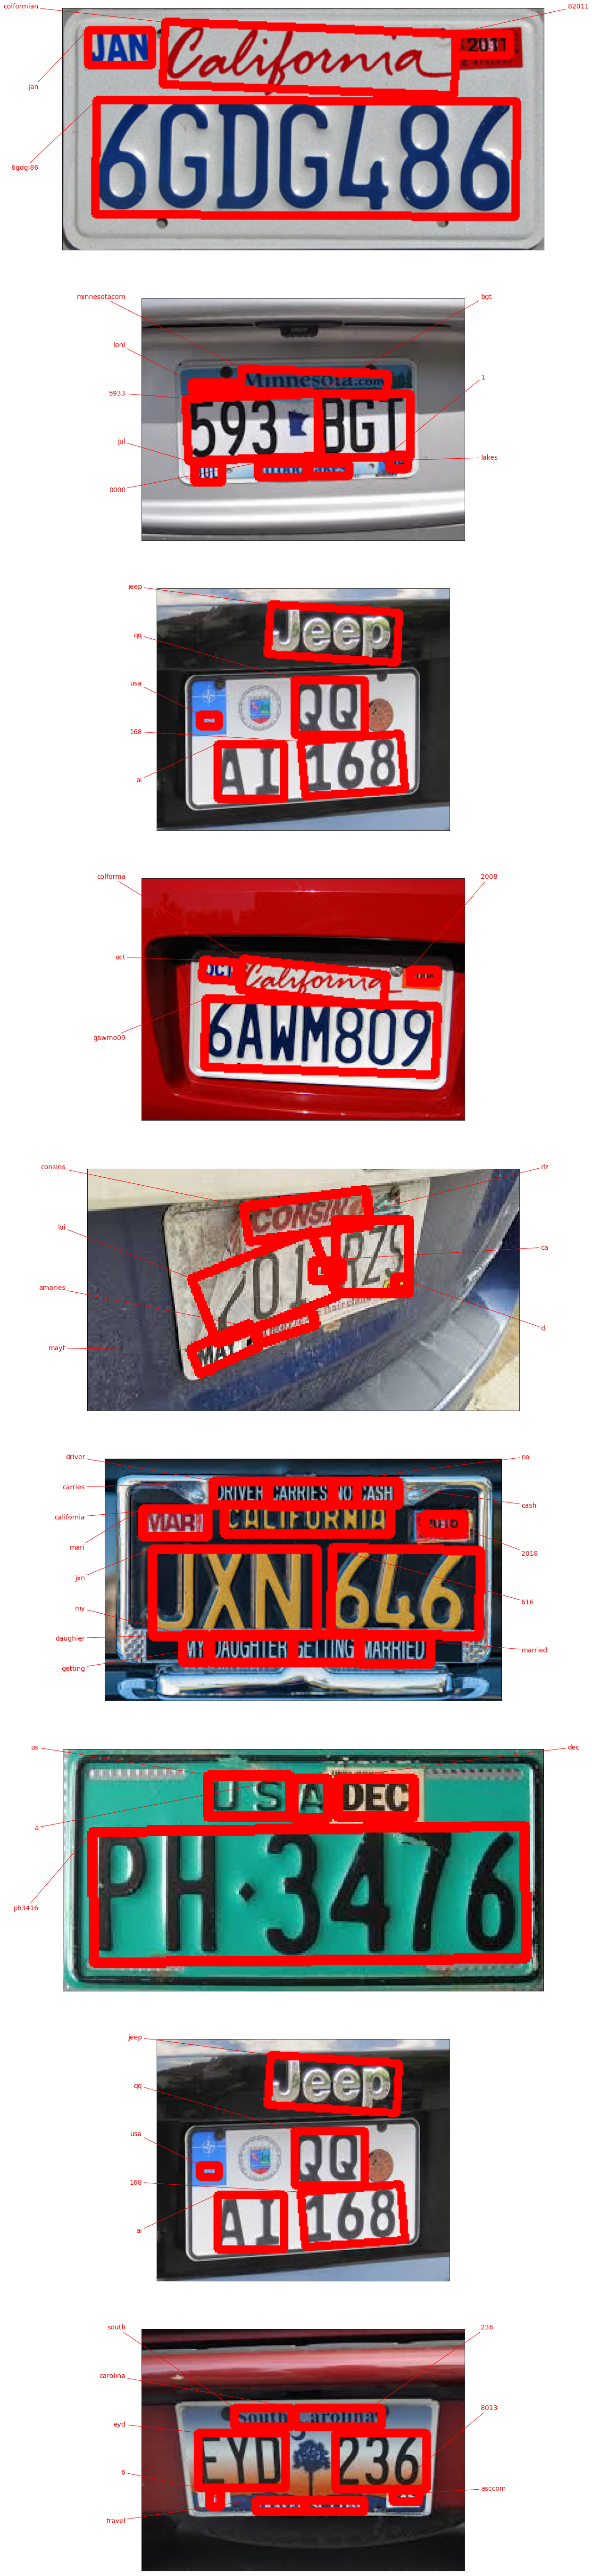

In [9]:
# Plot the predictions

fig, axs = plt.subplots(nrows=len(images), figsize=(30, 30) )
x = 100   # 가로 길이 
y = 100   # 세로 길이
fig.set_figwidth(x)
fig.set_figheight(y)


for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 태서랙트

In [20]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/plate/download1.jpeg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/aiffel-dj43/aiffel/ocr_python/0000.png
/home/aiffel-dj43/aiffel/ocr_python/0001.png
/home/aiffel-dj43/aiffel/ocr_python/0002.png
/home/aiffel-dj43/aiffel/ocr_python/0003.png
/home/aiffel-dj43/aiffel/ocr_python/0004.png
/home/aiffel-dj43/aiffel/ocr_python/0005.png
/home/aiffel-dj43/aiffel/ocr_python/0006.png


In [21]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

Seana

AANZ (26


Vi,

0686

pole

)

Done


# Step3. 테스트 결과 정리

우선 구글 API의 경우 결제 문제를 해결하지 못해 진행하지 못했습니다...  

keras-ocr의 경우 detection은 확실히 뛰어난 것 같습니다. 물론 단어를 정확하게 인식하지 못해서 이상하게 나누는 경우가 있긴 하지만 그래도 전반적으로 잘 인식하고 있습니다.  

이에 반해 Tesseract는 detection부터 제대로 되지 않아서 crop도 이상하게 잘라오는 경우가 많았습니다.

# Step4. 결과 분석과 결론 제시

#### 우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.

미국 드라이브 스루 매장을 가보면 항상 줄이 길게 늘어져 있습니다. 그리고 대부분의 음식 매장이 드라이브 스루 형태입니다.  

드라이브 스루에서 음식을 주문할때의 순서는 1. 주문하기 2. 조리되는 동안 대기 3. 결제하기입니다.  

만약 번호판을 인식해서 자동으로 주문과 결제가 된다면 음식이 조리되는 시간 동안 대기만 하면 됩니다. 동일 시간 동안 소화해낼 수 있는 물량이 달라질거라 생각합니다.  

따라서 정확한 번호판 인식이 매우 중요한데 미국에는 다양한 형태의 번호판이 존재합니다. 가장 좋은 성능을 보이는 구글API를 이용한다면 이미 거의 완벽하게 인식하고 있어 실제로 사용 가능한 모델 중 하나이지 않을까 생각합니다(구글 API는 다른 분들 결과를 참고했습니다.)